## Scanpy `pbmc4k`

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from fingerprint import SingleCellFingerprintBase
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
results_out_root = '/home/jupyter/mb-ml-dev-disk/data/10x/out/'

input_root = '/home/jupyter/mb-ml-dev-disk/data/10x/pbmc4k__alevin__raw__mtx_output/'
output_prefix = 'pbmc4k_raw'
louvain_resolution = 0.7
sc_fingerprint_path = '/home/jupyter/mb-ml-dev-disk/data/10x/pbmc4k_alevin_sc_fingerprint.pkl'
# input_root = '/home/jupyter/data/10x/out/pbmc4k__all_genes__11__final_3_weakreg__mtx_output/'
# output_prefix = 'pbmc4k_dtm'
# louvain_resolution = 1.0

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = os.path.join(results_out_root, f'{output_prefix}.h5ad')
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [3]:
fp = SingleCellFingerprintBase.load(sc_fingerprint_path)

In [4]:
adata = sc.read_10x_mtx(
    input_root,
    var_names='gene_symbols',
    cache=True) 

... writing an h5ad cache file to speedup reading next time


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [6]:
adata

AnnData object with n_obs × n_vars = 5391 × 15580 
    var: 'gene_ids'

## Preprocessing

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


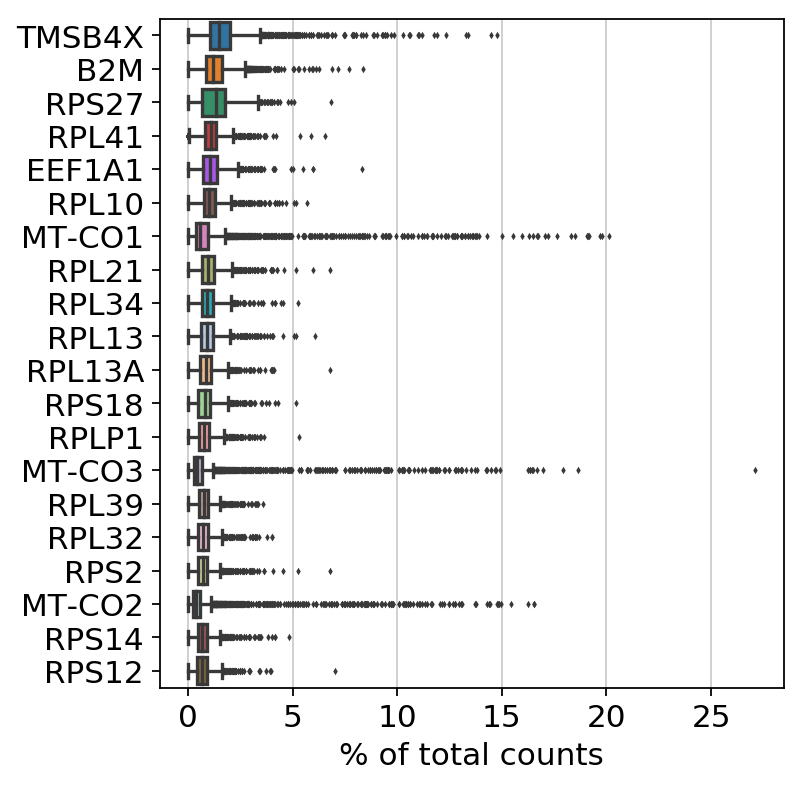

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, save="_" + output_prefix + '.pdf')

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 573 cells that haveless than 200 genes expressed
filtered out 1356 genes that are detectedin less than 3 cells


In [9]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'gene_ids' as categorical


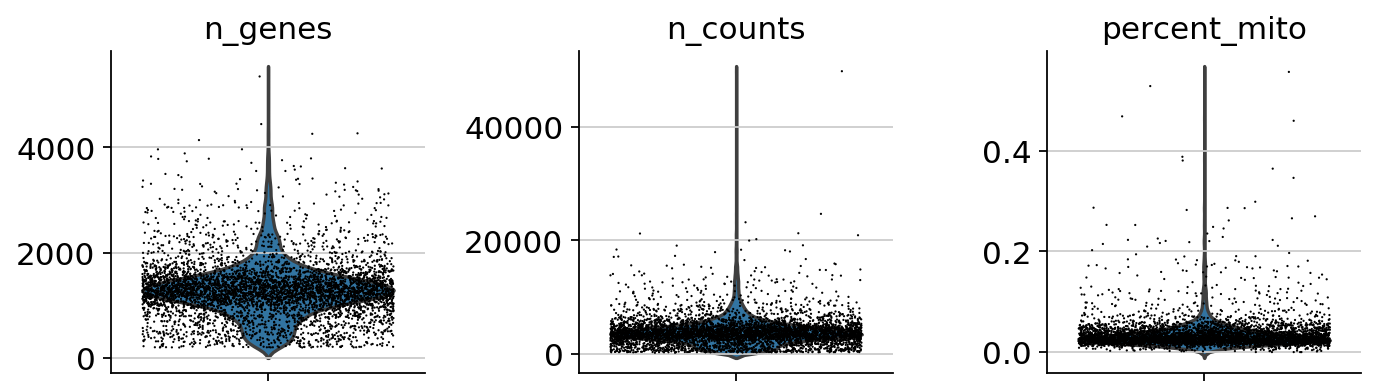

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

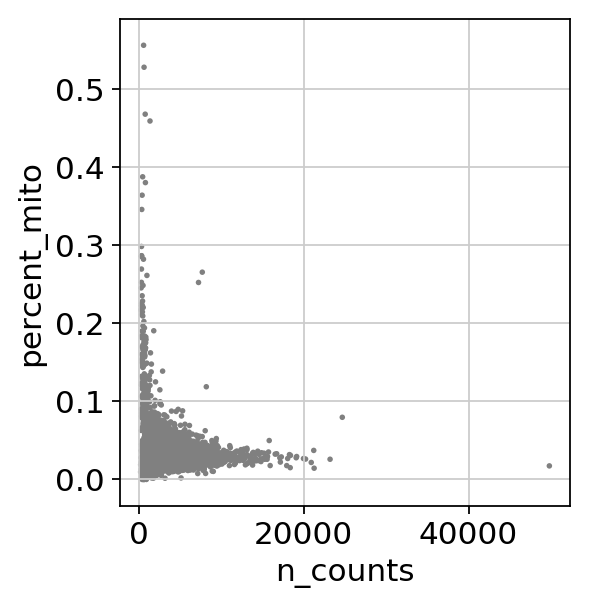

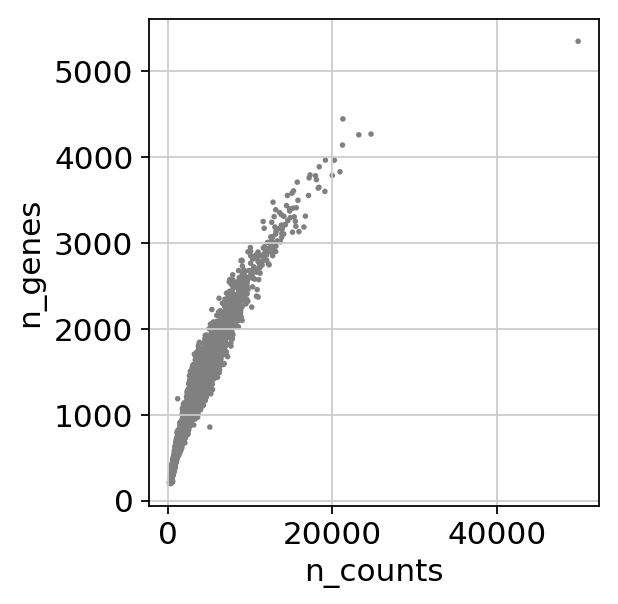

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 4818 × 14224 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.log1p(adata)

In [17]:
adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


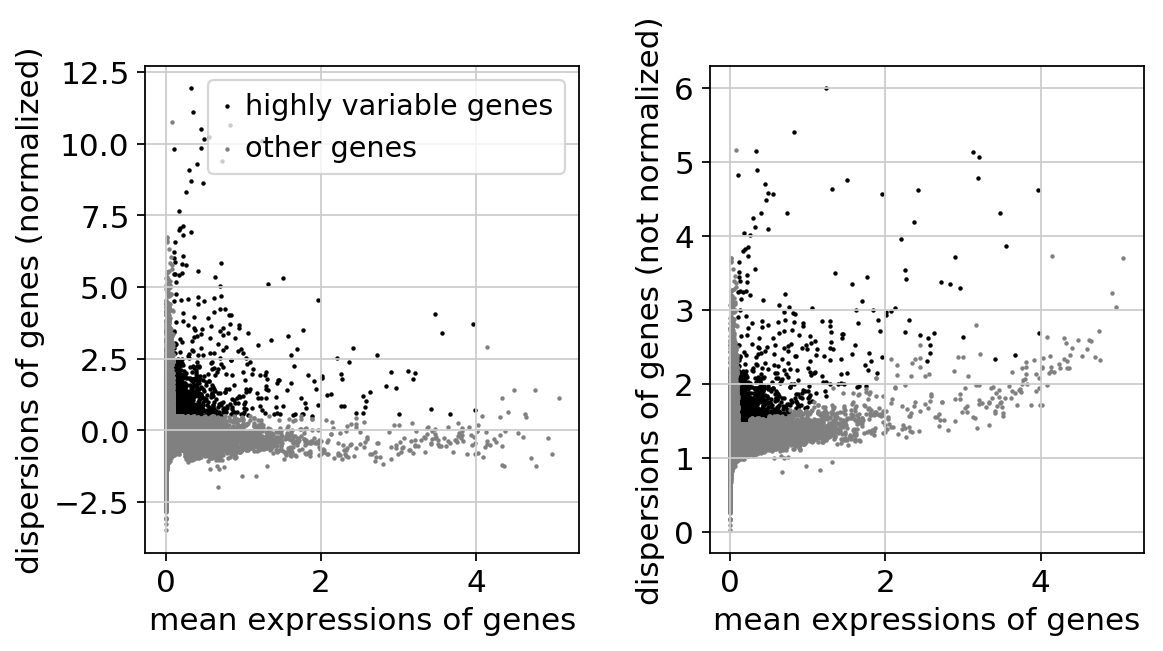

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata = adata[:, adata.var['highly_variable']]

In [21]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [22]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [23]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=200)

computing PCA with n_comps = 200
computing PCA on highly variable genes
    finished (0:00:00)


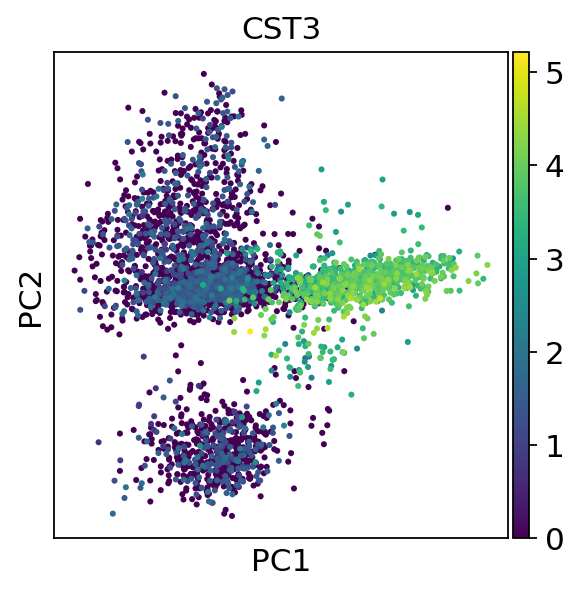

In [24]:
sc.pl.pca(adata, color='CST3')

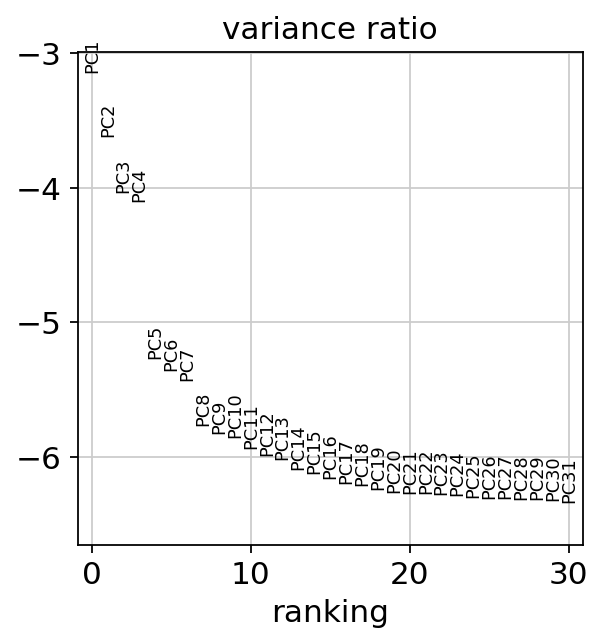

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 4019 × 1214 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


## Visualizing family sizes

In [30]:
from commons import encode, decode

In [31]:
sc_barcodes = adata.obs.index
sc_encoded_barcodes = []
for barcode in sc_barcodes:
    sc_encoded_barcodes.append(encode(barcode[:16]))
sc_to_fp_map = {
    barcode_index: fp.barcode_list.index(sc_encoded_barcodes[barcode_index])
    for barcode_index in range(len(sc_encoded_barcodes))
}

In [43]:
gene_name = 'IGHG4'
gene_index = fp.gene_names_list.index(gene_name)
min_fs = 1
max_fs = 10

expr_by_fs = dict()
for fs in range(min_fs, max_fs + 1):
    expr = []
    for barcode_index in range(len(sc_encoded_barcodes)):
        fp_barcode = fp.barcode_list[sc_to_fp_map[barcode_index]]
        expr.append(fp[fp_barcode][gene_index, fs - 1])
    expr_by_fs[fs] = expr

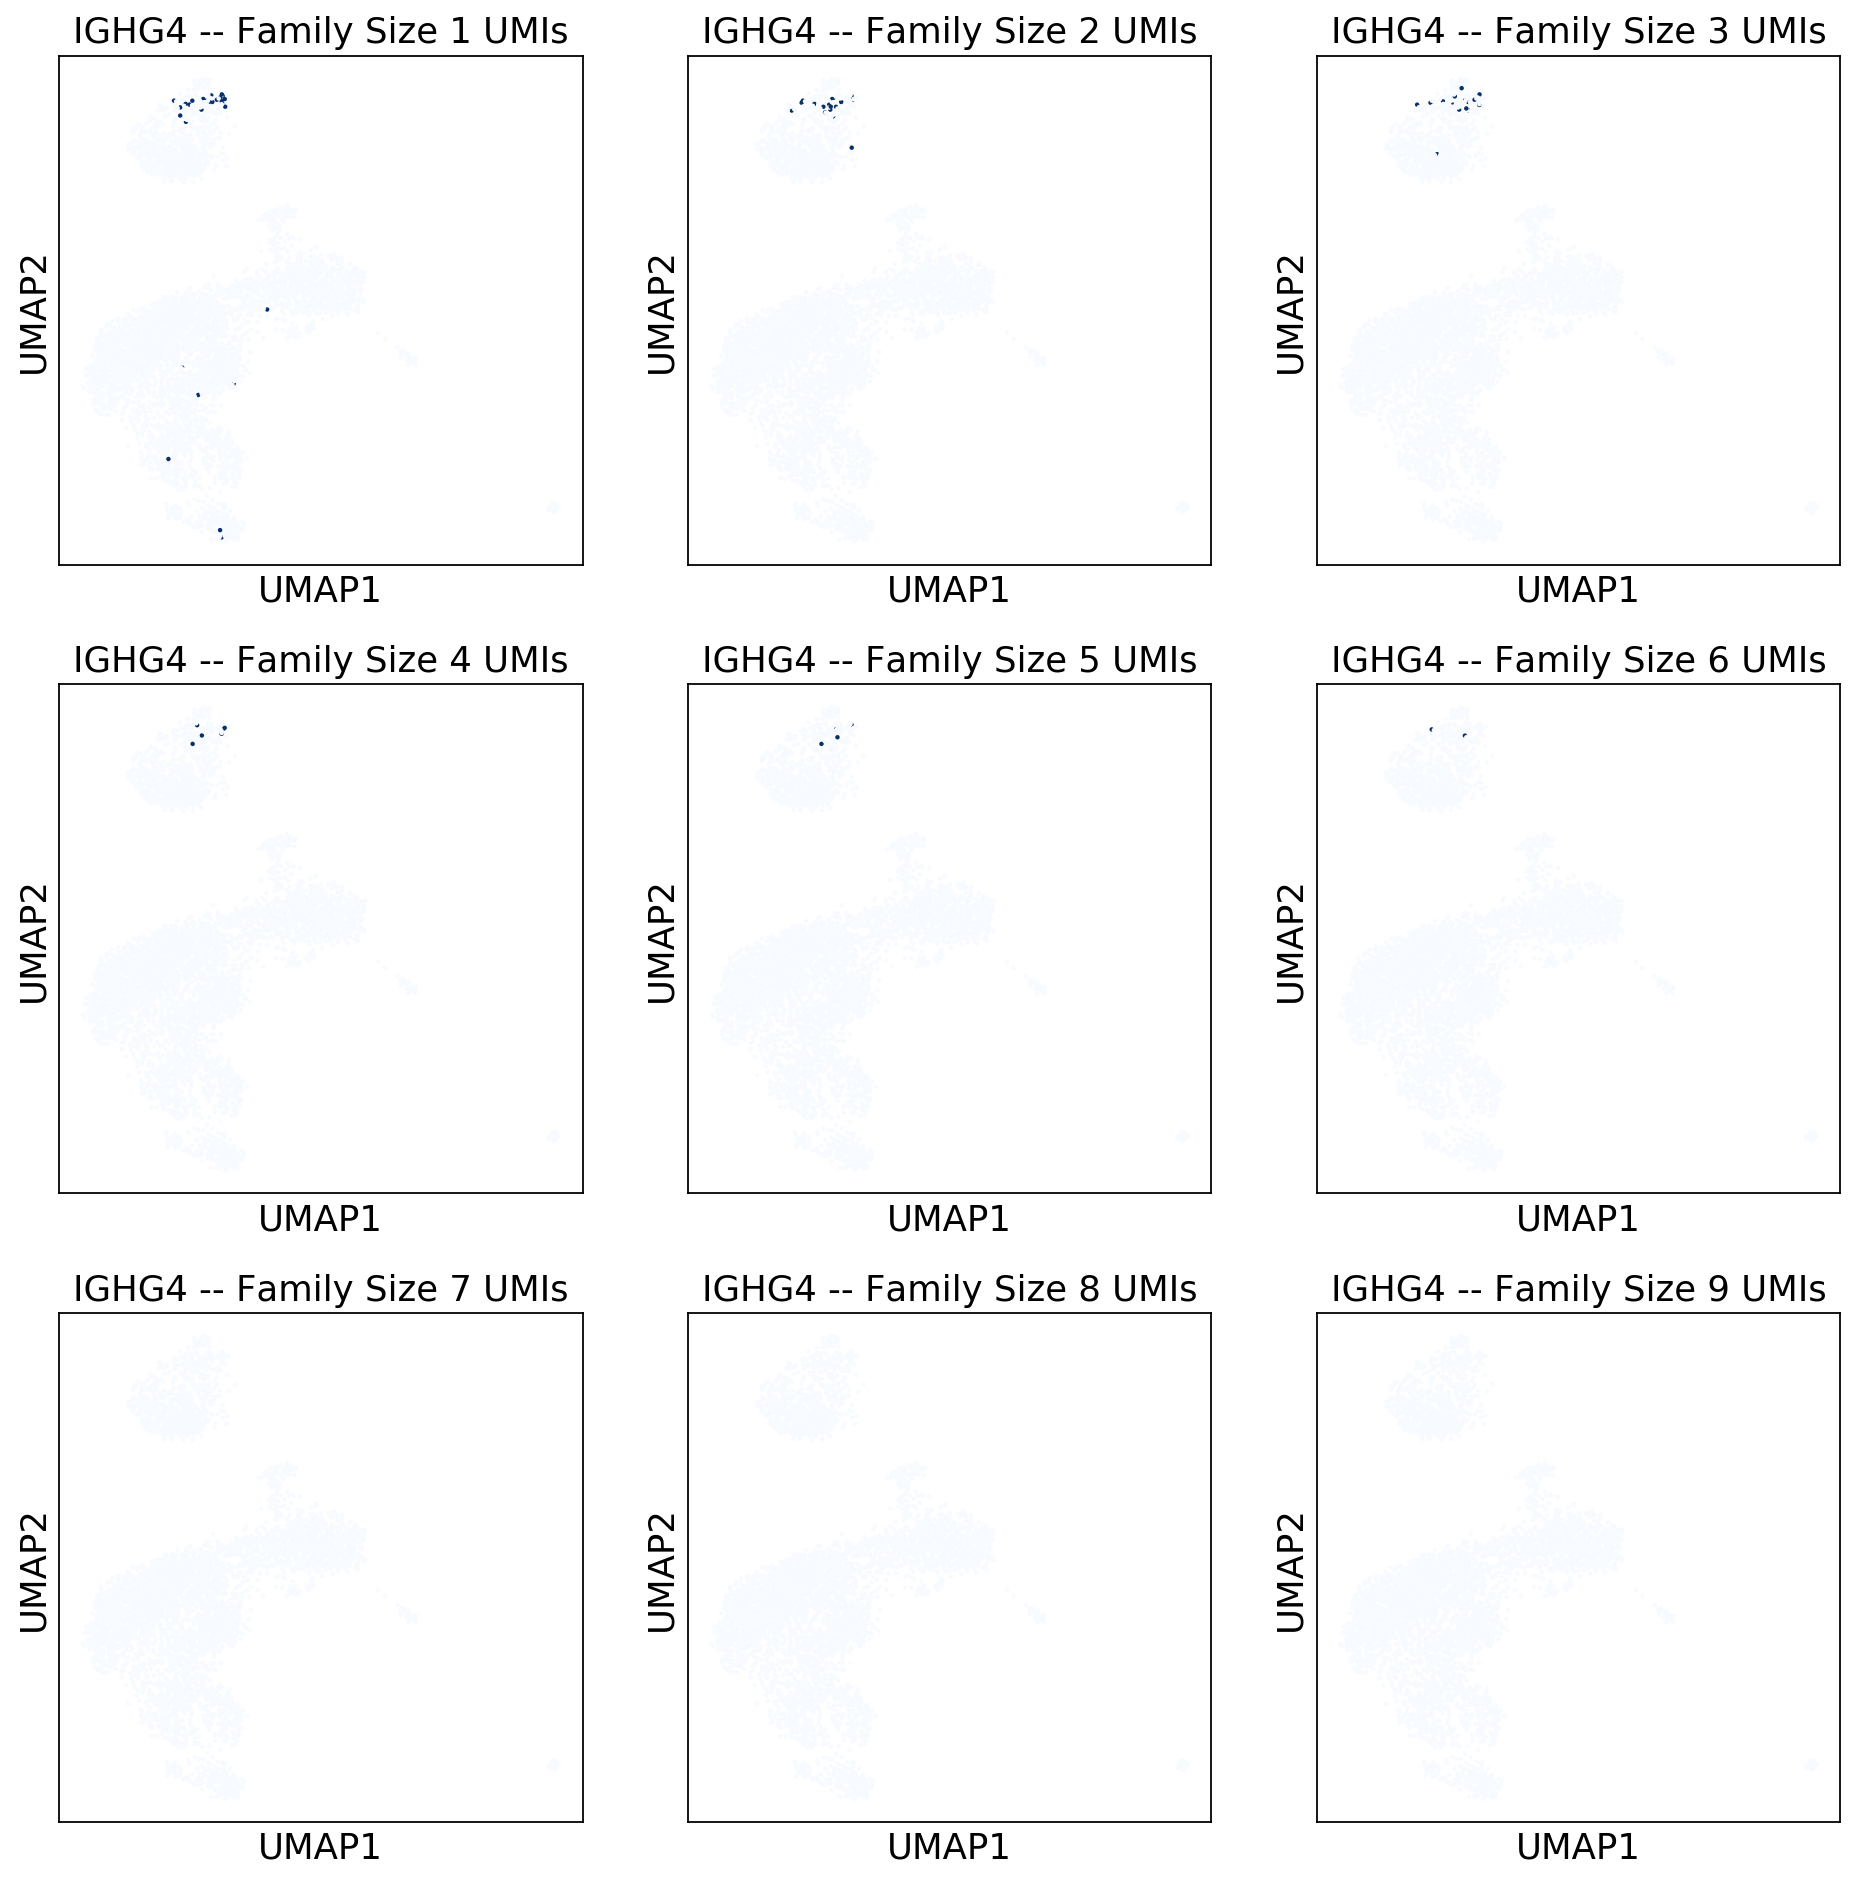

In [44]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
fs = 1
for j in range(3):
    for i in range(3):
        ax = axs[j, i]
        im = ax.scatter(adata.obsm['X_umap'][:, 0],
                    adata.obsm['X_umap'][:, 1],
                    s=1,
                    c=np.log1p(expr_by_fs[fs]) > 0,
                    cmap=plt.cm.Blues)
        ax.grid(False)
        ax.set_title(f'{gene_name} -- Family Size {fs} UMIs', fontsize=16)
        ax.set_xlabel('UMAP1', fontsize=16)
        ax.set_ylabel('UMAP2', fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        
        fs += 1

plt.tight_layout()
# plt.savefig(f'/home/jupyter/CellBender/proto/chimera/notebooks/figures/cst3_umap_fs_{fs}.png', dpi=100)